<a href="https://colab.research.google.com/github/Yosra-01/Satellite-Image-Classifier-/blob/main/Satellite_MobileNetV2_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
%pip install -q kagglehub

In [2]:
%pip install tensorflow scikit-learn -q

In [3]:
#import all libraries expected to be needed
import kagglehub

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from sklearn.model_selection import train_test_split
import shutil
from pathlib import Path
import json



In [4]:
from tensorflow.keras.applications import MobileNetV2

In [5]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation)
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import (
    CategoricalAccuracy, TopKCategoricalAccuracy,
    Precision, Recall, AUC
)

# **Download Dataset**

In [6]:
# Download dataset using Kaggle Hub
dataset_path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")
print("Path to dataset files:", dataset_path)

# Find the data folder
if os.path.exists(os.path.join(dataset_path, "data")):
    dataset_path = os.path.join(dataset_path, "data")

Using Colab cache for faster access to the 'satellite-image-classification' dataset.
Path to dataset files: /kaggle/input/satellite-image-classification


# **Dataset Exploration**

## **Inspect Structure**

In [7]:
classes = os.listdir(dataset_path)

class_counts = {}
for cls in classes:
    class_counts[cls] = len(os.listdir(os.path.join(dataset_path, cls)))

class_counts


{'cloudy': 1500, 'desert': 1131, 'green_area': 1500, 'water': 1500}

## **Plot Class Distribution**

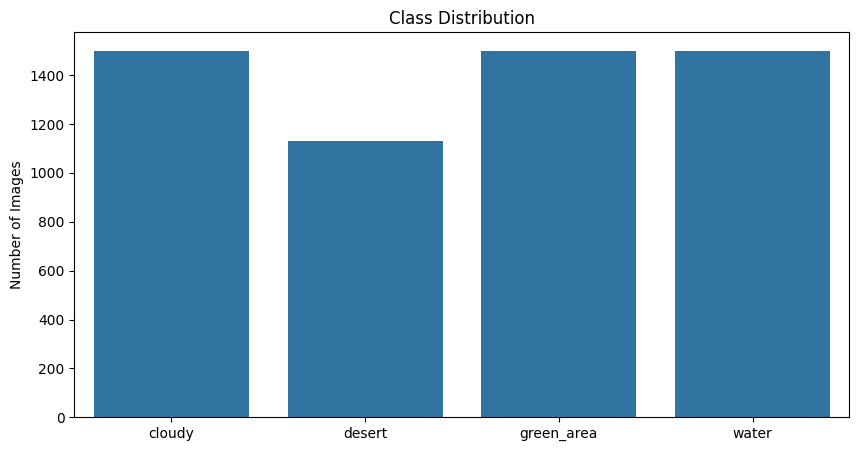

In [8]:

plt.figure(figsize=(10,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()


## **Show sample from each class**

### **first image in each class**

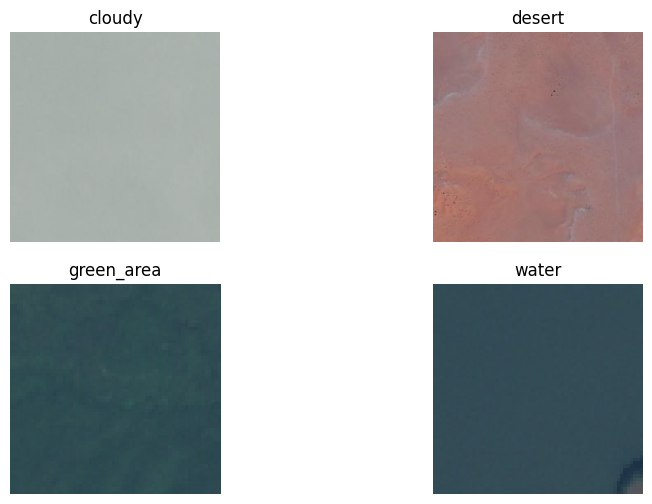

In [9]:
plt.figure(figsize=(10,6))

for i, cls in enumerate(classes):
    img_path = os.path.join(dataset_path, cls, os.listdir(os.path.join(dataset_path, cls))[0])
    img = plt.imread(img_path)

    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.show()




### **random image from each class**

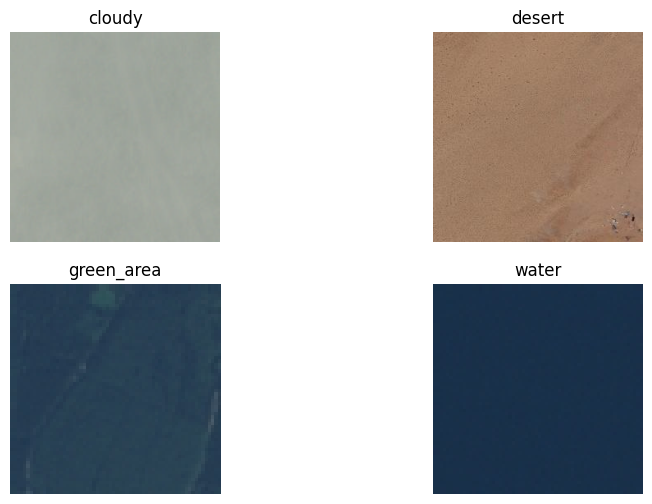

In [10]:
import random

plt.figure(figsize=(10,6))

for i, cls in enumerate(classes):
    cls_path = os.path.join(dataset_path, cls)
    images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.png','.jpeg'))]

    img_path = os.path.join(cls_path, random.choice(images))
    img = plt.imread(img_path)

    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.show()


# **Data Preparation**

## **Load dataset**

In [11]:
dataset_dir = Path(dataset_path)
class_names = sorted([d.name for d in dataset_dir.iterdir() if d.is_dir()])
print(f"\nClass names:")
for name in class_names:
    print(f"  - {name}")


Class names:
  - cloudy
  - desert
  - green_area
  - water


## **Stratified Splitting**

In [12]:
# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create directories
base_dir = Path("/content/split_data")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"

for split_dir in [train_dir, val_dir, test_dir]:
    split_dir.mkdir(parents=True, exist_ok=True)
    for class_name in class_names:
        (split_dir / class_name).mkdir(exist_ok=True)

# Split images for each class
for class_name in class_names:
    class_path = dataset_dir / class_name
    image_files = [f for f in class_path.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]

    n_total = len(image_files)

    # First split: separate test set
    train_val_files, test_files = train_test_split(image_files,test_size=test_ratio,random_state=42,shuffle=True)

    # Second split: separate train and val
    # Calculate val size relative to train_val
    val_size_adjusted = val_ratio / (train_ratio + val_ratio)
    train_files, val_files = train_test_split(train_val_files,test_size=val_size_adjusted,random_state=42,shuffle=True)

    print(f"{class_name:15s}: Total={n_total:4d}, "
          f"Train={len(train_files):4d} ({len(train_files)/n_total*100:.1f}%), "
          f"Val={len(val_files):4d} ({len(val_files)/n_total*100:.1f}%), "
          f"Test={len(test_files):4d} ({len(test_files)/n_total*100:.1f}%)")

    # Verify no images lost
    assert len(train_files) + len(val_files) + len(test_files) == n_total, f"Image count mismatch for {class_name}"

    # Copy files
    for img_file in train_files:
        shutil.copy(img_file, train_dir / class_name / img_file.name)

    for img_file in val_files:
        shutil.copy(img_file, val_dir / class_name / img_file.name)

    for img_file in test_files:
        shutil.copy(img_file, test_dir / class_name / img_file.name)

cloudy         : Total=1500, Train=1049 (69.9%), Val= 226 (15.1%), Test= 225 (15.0%)
desert         : Total=1131, Train= 791 (69.9%), Val= 170 (15.0%), Test= 170 (15.0%)
green_area     : Total=1500, Train=1049 (69.9%), Val= 226 (15.1%), Test= 225 (15.0%)
water          : Total=1500, Train=1049 (69.9%), Val= 226 (15.1%), Test= 225 (15.0%)


# **Base Model & Develop architecture**

## ***meta data***

In [13]:
#Check
print("="*80)
print("MOBILENET TRANSFER LEARNING - IMPORT SUCCESSFUL")
print("="*80)
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"GPU Available: {tf.test.gpu_device_name()}")
print(f"GPU Devices: {tf.config.list_physical_devices('GPU')}")
print("="*80)

MOBILENET TRANSFER LEARNING - IMPORT SUCCESSFUL
TensorFlow Version: 2.19.0
Keras Version: 3.10.0
GPU Available: /device:GPU:0
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [19]:
"""
MobileNetV2 Architecture Overview:
---------------------------------
• Uses depthwise separable convolutions
• Pre-trained on ImageNet (1.4M images, 1000 classes)

Key Features:
-------------
• Input size: 224x224x3 (RGB images)
• Total layers: 154 layers
• Parameters: ~3.5 million (lightweight!)

Why MobileNet for This Project?
--------------------------------
• Excellent for image classification
• Fast training with transfer learning
• Good accuracy with fewer parameters
• Works well with limited data
"""

'\nMobileNetV2 Architecture Overview:\n---------------------------------\n• Uses depthwise separable convolutions\n• Pre-trained on ImageNet (1.4M images, 1000 classes)\n\nKey Features:\n-------------\n• Input size: 224x224x3 (RGB images)\n• Total layers: 154 layers\n• Parameters: ~3.5 million (lightweight!)\n\nWhy MobileNet for This Project?\n--------------------------------\n• Excellent for image classification\n• Fast training with transfer learning\n• Good accuracy with fewer parameters\n• Works well with limited data\n'

## **Loading Base Model**

### **Configuration**

In [14]:
# Configuration
IMG_SIZE = (224, 224)  # MobileNet standard input size
IMG_SHAPE = IMG_SIZE + (3,)  # (224, 224, 3)
NUM_CLASSES = 4

print(f"Image size: {IMG_SIZE}")
print(f"Image shape: {IMG_SHAPE}")
print(f"Number of classes: {NUM_CLASSES}")

Image size: (224, 224)
Image shape: (224, 224, 3)
Number of classes: 4


### **Load MobileNetV2**

In [15]:
# Load MobileNetV2
print("\nLoading MobileNetV2...")
base_model = MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,   # Exclude ImageNet classifier
    weights='imagenet'   # Use ImageNet pre-trained weights
)
print(" MobileNetV2 base model loaded successfully!")
print(f"   Input shape: {base_model.input_shape}")
print(f"   Output shape: {base_model.output_shape}")


Loading MobileNetV2...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
 MobileNetV2 base model loaded successfully!
   Input shape: (None, 224, 224, 3)
   Output shape: (None, 7, 7, 1280)


### **Explore Model Architecture**

In [16]:
# Display model summary
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

### **Freeze Base Layers**

In [17]:
#TRANSFER LEARNING STRATEGY: Feature Extraction

# Freeze all layers in the base model
base_model.trainable = False

#verify layers are frozen
trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
print(f"Base model frozen: {trainable_count}/{len(base_model.layers)} layers trainable")

Base model frozen: 0/154 layers trainable


## **Proposed Architecture**

In [18]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(name='global_avg_pool'),
    Dense(256, activation='relu', name='dense_256'),
    BatchNormalization(name='batch_norm'),
    Dropout(0.5, name='dropout'),
    Dense(NUM_CLASSES, activation='softmax', name='predictions')
], name='MobileNetV2_Satellite_Classifier')

print("Model architecture built successfully!")

Model architecture built successfully!


In [19]:
model.summary()

Model: "MobileNetV2_Satellite_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm (BatchNormalization) │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,972 (9.87 MB)

 Trainable params: 329,476 (1.26 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

# **Functions**

## **Build Model Function**

In [20]:
def build_model(num_classes, input_shape=(224, 224, 3), freeze_base=True, learning_rate=0.001):

    # Load pre-trained base model
    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False,  # Exclude ImageNet classifier
                             weights='imagenet'  # Use ImageNet pre-trained weights
                             )

    # Freeze base layers based on strategy
    if freeze_base == True:
        base_model.trainable = False
        print(" base layers frozen (transfer learning mode)")
    elif freeze_base == 'partial':
        # Freeze all layers except the last 20
        for layer in base_model.layers[:-20]:
            layer.trainable = False
        for layer in base_model.layers[-20:]:
            layer.trainable = True
        print(" partial fine-tuning: last 20 layers trainable")
    else:
        base_model.trainable = True
        print("base layers trainable (full fine-tuning mode)")

    # Build model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(name='global_avg_pool'),
        Dense(256, activation='relu', name='dense_256'),
        BatchNormalization(name='batch_norm'),
        Dropout(0.5, name='dropout'),
        Dense(num_classes, activation='softmax', name='predictions')
    ], name='MobileNetV2_Satellite_Classifier')


    # Compile model (setting up training configuration)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

print("Model builder function created")

Model builder function created


## **Experiments Function**

In [27]:
def run_experiment(experiment_name, freeze_base=True, use_augmentation=False,
                   learning_rate=0.001, batch_size=32, epochs=20, patience=5):

    print("="*60)
    print(f"EXPERIMENT: {experiment_name}")
    print("="*60)
    print(f"  Freeze Base: {freeze_base}")
    print(f"  Augmentation: {use_augmentation}")
    print(f"  Learning Rate: {learning_rate}")
    print(f"  Batch Size: {batch_size}")
    print(f"  Max Epochs: {epochs}")
    print("="*60)

    # Create data generators
    if use_augmentation:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2
        )
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)

    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=IMG_SIZE, batch_size=batch_size,
        class_mode='categorical', shuffle=True
    )
    val_gen = val_datagen.flow_from_directory(
        val_dir, target_size=IMG_SIZE, batch_size=batch_size,
        class_mode='categorical', shuffle=False
    )
    test_gen = test_datagen.flow_from_directory(
        test_dir, target_size=IMG_SIZE, batch_size=batch_size,
        class_mode='categorical', shuffle=False
    )

    # Build model
    model = build_model(
        num_classes=4,
        input_shape=(224, 224, 3),
        freeze_base=freeze_base,
        learning_rate=learning_rate
    )

    # Create callbacks
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience,
        restore_best_weights=True, verbose=1
    )

    # Train model
    history = model.fit(
        train_gen, epochs=epochs,
        validation_data=val_gen,
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_gen, verbose=0)

    # Generate predictions for detailed metrics
    test_gen.reset()
    y_pred_probs = model.predict(test_gen, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0)

    # Store results
    results = {
        'experiment_name': experiment_name,
        'freeze_base': freeze_base,
        'augmentation': use_augmentation,
        'learning_rate': learning_rate,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'history': history.history,
        'epochs_trained': len(history.history['loss']),
        'y_true': y_true,
        'y_pred': y_pred,
        'class_names': class_names
    }

    print(f"\n✓ {experiment_name} Complete!")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Epochs Trained: {results['epochs_trained']}")

    return results

print("Experiment runner function created")

Experiment runner function created


## **Cross Validation Function**


In [58]:
def run_experiment_with_cv(experiment_name, n_folds=5, freeze_base=True,
                           use_augmentation=False, learning_rate=0.001,
                           batch_size=32, epochs=20, patience=5):
    """
    Run k-fold cross-validation experiment
    """
    print("="*60)
    print(f"CROSS-VALIDATION EXPERIMENT: {experiment_name}")
    print("="*60)
    print(f"  N-Folds: {n_folds}")
    print(f"  Freeze Base: {freeze_base}")
    print(f"  Augmentation: {use_augmentation}")
    print(f"  Learning Rate: {learning_rate}")
    print(f"  Batch Size: {batch_size}")
    print(f"  Max Epochs: {epochs}")
    print("="*60)

    from sklearn.model_selection import KFold
    import shutil
    import os

    # Combine train and val directories for CV
    # First, collect all image paths and labels
    all_images = []
    all_labels = []

    for class_idx, class_name in enumerate(class_names):
        # Get images from train directory
        train_class_dir = os.path.join(train_dir, class_name)
        if os.path.exists(train_class_dir):
            for img_name in os.listdir(train_class_dir):
                img_path = os.path.join(train_class_dir, img_name)
                all_images.append(img_path)
                all_labels.append(class_idx)

        # Get images from validation directory
        val_class_dir = os.path.join(val_dir, class_name)
        if os.path.exists(val_class_dir):
            for img_name in os.listdir(val_class_dir):
                img_path = os.path.join(val_class_dir, img_name)
                all_images.append(img_path)
                all_labels.append(class_idx)

    all_images = np.array(all_images)
    all_labels = np.array(all_labels)

    print(f"\nTotal samples for CV: {len(all_images)}")

    # Initialize KFold
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Store results for each fold
    fold_results = []
    fold_histories = []

    # Create temporary directories for CV splits
    temp_cv_dir = 'temp_cv_split'
    os.makedirs(temp_cv_dir, exist_ok=True)

    for fold_idx, (train_indices, val_indices) in enumerate(kfold.split(all_images)):
        print(f"\n{'='*60}")
        print(f"FOLD {fold_idx + 1}/{n_folds}")
        print(f"{'='*60}")

        # Create fold-specific directories
        fold_train_dir = os.path.join(temp_cv_dir, f'fold_{fold_idx}', 'train')
        fold_val_dir = os.path.join(temp_cv_dir, f'fold_{fold_idx}', 'val')

        # Create class subdirectories
        for class_name in class_names:
            os.makedirs(os.path.join(fold_train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(fold_val_dir, class_name), exist_ok=True)

        # Copy images to fold directories
        for idx in train_indices:
            img_path = all_images[idx]
            class_name = class_names[all_labels[idx]]
            img_name = os.path.basename(img_path)
            dst_path = os.path.join(fold_train_dir, class_name, img_name)
            shutil.copy2(img_path, dst_path)

        for idx in val_indices:
            img_path = all_images[idx]
            class_name = class_names[all_labels[idx]]
            img_name = os.path.basename(img_path)
            dst_path = os.path.join(fold_val_dir, class_name, img_name)
            shutil.copy2(img_path, dst_path)

        # Create data generators for this fold
        if use_augmentation:
            train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                zoom_range=0.2
            )
        else:
            train_datagen = ImageDataGenerator(rescale=1./255)

        val_datagen = ImageDataGenerator(rescale=1./255)

        fold_train_gen = train_datagen.flow_from_directory(
            fold_train_dir, target_size=IMG_SIZE, batch_size=batch_size,
            class_mode='categorical', shuffle=True
        )
        fold_val_gen = val_datagen.flow_from_directory(
            fold_val_dir, target_size=IMG_SIZE, batch_size=batch_size,
            class_mode='categorical', shuffle=False
        )

        # Build and train model for this fold
        model = build_model(
            num_classes=4,
            input_shape=(224, 224, 3),
            freeze_base=freeze_base,
            learning_rate=learning_rate
        )

        early_stop = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=patience,
            restore_best_weights=True, verbose=1
        )

        history = model.fit(
            fold_train_gen, epochs=epochs,
            validation_data=fold_val_gen,
            callbacks=[early_stop],
            verbose=1
        )

        # Evaluate on validation fold
        val_loss, val_accuracy = model.evaluate(fold_val_gen, verbose=0)

        # Store fold results
        fold_results.append({
            'fold': fold_idx + 1,
            'val_accuracy': val_accuracy,
            'val_loss': val_loss,
            'epochs_trained': len(history.history['loss'])
        })
        fold_histories.append(history.history)

        print(f"Fold {fold_idx + 1} Results:")
        print(f"  Val Accuracy: {val_accuracy:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  Epochs: {len(history.history['loss'])}")

        # Clean up fold directories
        shutil.rmtree(os.path.join(temp_cv_dir, f'fold_{fold_idx}'))

        # Clear session to free memory
        keras.backend.clear_session()

    # Clean up temp directory
    shutil.rmtree(temp_cv_dir)

    # Calculate mean and std across folds
    accuracies = [r['val_accuracy'] for r in fold_results]
    losses = [r['val_loss'] for r in fold_results]

    cv_summary = {
        'experiment_name': experiment_name,
        'freeze_base': freeze_base,
        'augmentation': use_augmentation,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'n_folds': n_folds,
        'fold_results': fold_results,
        'fold_histories': fold_histories,
        'mean_accuracy': np.mean(accuracies),
        'std_accuracy': np.std(accuracies),
        'mean_loss': np.mean(losses),
        'std_loss': np.std(losses)
    }

    print(f"\n{'='*60}")
    print(f"CROSS-VALIDATION SUMMARY: {experiment_name}")
    print(f"{'='*60}")
    print(f"Mean Accuracy: {cv_summary['mean_accuracy']:.4f} ± {cv_summary['std_accuracy']:.4f}")
    print(f"Mean Loss: {cv_summary['mean_loss']:.4f} ± {cv_summary['std_loss']:.4f}")
    print(f"{'='*60}\n")

    return cv_summary


print("function created")

function created


## **Plotting CV**

In [64]:
def plot_cv_results(cv_summary):
    """Plot cross-validation results across folds"""
    fold_results = cv_summary['fold_results']
    folds = [r['fold'] for r in fold_results]
    accuracies = [r['val_accuracy'] for r in fold_results]
    losses = [r['val_loss'] for r in fold_results]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy across folds
    axes[0].bar(folds, accuracies, color='steelblue', alpha=0.7)
    axes[0].axhline(cv_summary['mean_accuracy'], color='red',
                    linestyle='--', label=f"Mean: {cv_summary['mean_accuracy']:.4f}")
    axes[0].set_title(f"Accuracy Across Folds - {cv_summary['experiment_name']}")
    axes[0].set_xlabel('Fold')
    axes[0].set_ylabel('Validation Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss across folds
    axes[1].bar(folds, losses, color='coral', alpha=0.7)
    axes[1].axhline(cv_summary['mean_loss'], color='red',
                    linestyle='--', label=f"Mean: {cv_summary['mean_loss']:.4f}")
    axes[1].set_title(f"Loss Across Folds - {cv_summary['experiment_name']}")
    axes[1].set_xlabel('Fold')
    axes[1].set_ylabel('Validation Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


print("function created")

function created


## **Plotting Performance Curves**

In [22]:
# Plotting functions
def plot_training_curves(results):
    """Plot training and validation accuracy/loss curves"""
    history = results['history']

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    axes[0].plot(history['accuracy'], label='Train Accuracy', marker='o')
    axes[0].plot(history['val_accuracy'], label='Val Accuracy', marker='s')
    axes[0].set_title(f"Training Curves - {results['experiment_name']}")
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(history['loss'], label='Train Loss', marker='o')
    axes[1].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[1].set_title(f"Loss Curves - {results['experiment_name']}")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(results):
    """Plot confusion matrix for an experiment"""
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(results['y_true'], results['y_pred'])

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=results['class_names'],
                yticklabels=results['class_names'])
    plt.title(f"Confusion Matrix - {results['experiment_name']}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

## **Compare Experiments Function**


In [45]:
def compare_experiments(all_results):
    """Compare metrics across all experiments"""
    metrics = ['test_accuracy', 'precision', 'recall', 'f1_score']
    exp_names = [r['experiment_name'] for r in all_results]

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        values = [r[metric] for r in all_results]
        axes[idx].bar(range(len(exp_names)), values, color='skyblue', edgecolor='navy')
        axes[idx].set_xticks(range(len(exp_names)))
        axes[idx].set_xticklabels(exp_names, rotation=45, ha='right')
        axes[idx].set_ylabel(metric.replace('_', ' ').title())
        axes[idx].set_title(f'{metric.replace("_", " ").title()} Comparison')
        axes[idx].grid(True, alpha=0.3, axis='y')

        # Add value labels on bars
        for i, v in enumerate(values):
            axes[idx].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()

# **Define Experiments to Run**


In [24]:
# Define experiments with different batch sizes and learning rates
experiments = [
    {
        'name': 'Baseline (BS=32, LR=0.001)',
        'freeze_base': True,
        'use_augmentation': False,
        'learning_rate': 0.001,
        'batch_size': 32
    },
    {
        'name': 'Small Batch (BS=16, LR=0.001)',
        'freeze_base': True,
        'use_augmentation': False,
        'learning_rate': 0.001,
        'batch_size': 16 ##
    },
    {
        'name': 'Large Batch (BS=64, LR=0.001)',
        'freeze_base': True,
        'use_augmentation': False,
        'learning_rate': 0.001,
        'batch_size': 64 ##
    },
    {
        'name': 'High LR (BS=32, LR=0.01)',
        'freeze_base': True,
        'use_augmentation': False,
        'learning_rate': 0.01, ##
        'batch_size': 32
    },
    {
        'name': 'Low LR (BS=32, LR=0.0001)',
        'freeze_base': True,
        'use_augmentation': False,
        'learning_rate': 0.0001, ##
        'batch_size': 32
    },
    {
        'name': 'Augmentation (BS=32, LR=0.001)',
        'freeze_base': True,
        'use_augmentation': True, ##
        'learning_rate': 0.001,
        'batch_size': 32
    },
    {
        'name': 'Fine-tuning (No Aug)',
        'freeze_base': 'partial', ##
        'use_augmentation': False,
        'learning_rate': 0.0001,  # Lower LR for fine-tuning
        'batch_size': 32
    },
    {
        'name': 'Fine-tune (BS=32, LR=0.0001)',
        'freeze_base': 'partial', ##
        'use_augmentation': True,
        'learning_rate': 0.0001,
        'batch_size': 32
    }
]

print(f"Defined {len(experiments)} experiments:")
for exp in experiments:
    print(f"  - {exp['name']}")

Defined 8 experiments:
  - Baseline (BS=32, LR=0.001)
  - Small Batch (BS=16, LR=0.001)
  - Large Batch (BS=64, LR=0.001)
  - High LR (BS=32, LR=0.01)
  - Low LR (BS=32, LR=0.0001)
  - Augmentation (BS=32, LR=0.001)
  - Fine-tuning (No Aug)
  - Fine-tune (BS=32, LR=0.0001)


# **Run CV**

CROSS-VALIDATION EXPERIMENT: Exp1: Baseline with CV
  N-Folds: 5
  Freeze Base: True
  Augmentation: False
  Learning Rate: 0.001
  Batch Size: 32
  Max Epochs: 20

Total samples for CV: 4786

FOLD 1/5
Found 3828 images belonging to 4 classes.
Found 958 images belonging to 4 classes.
 base layers frozen (transfer learning mode)
Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 45s 303ms/step - accuracy: 0.8840 - loss: 0.3095 - val_accuracy: 0.9405 - val_loss: 0.1612
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9784 - loss: 0.0761 - val_accuracy: 0.9363 - val_loss: 0.1519
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9756 - loss: 0.0754 - val_accuracy: 0.9823 - val_loss: 0.0510
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9810 - loss: 0.0573 - val_accuracy: 0.9906 - val_loss: 0.0353
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9915 - loss: 0.0323 - val_accuracy: 0.9864 - val_loss: 0.0392
Epoch 6/20
120/120 ━━━

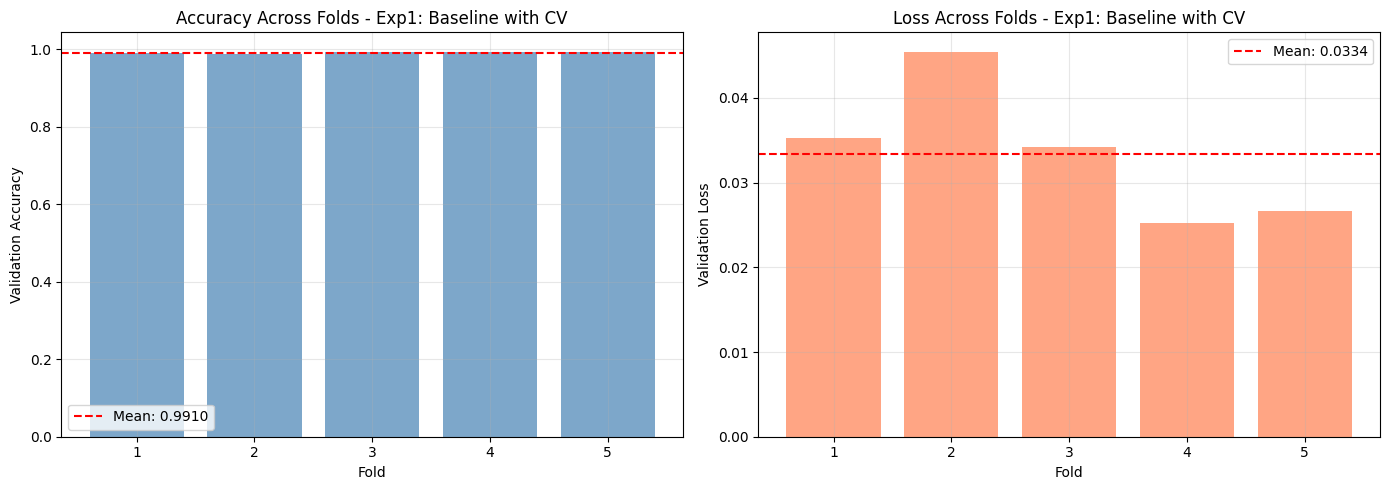

In [63]:
# Run CV experiment
cv_results_exp1 = run_experiment_with_cv(
    experiment_name="Exp1: Baseline with CV",
    n_folds=5,
    freeze_base=True,
    learning_rate=0.001,
    batch_size=32,
    epochs=20,
    patience=5
)

# Plot CV results
plot_cv_results(cv_results_exp1)

# **Run Experiments**

In [37]:
# Initialize results list (run this cell first)
all_results = []
EPOCHS = 50  # Maximum epochs per experiment
PATIENCE = 10  # Early stopping patience

print("✓ Results list initialized. Run individual experiment cells below.")


✓ Results list initialized. Run individual experiment cells below.


## **1-Baseline (transfer learning, LR=0.001, BS=32)**

In [34]:
# Run Experiment 1: Baseline (Frozen, No Augmentation)
result1 = run_experiment(
    experiment_name=experiments[0]['name'],
    freeze_base=experiments[0]['freeze_base'],
    use_augmentation=experiments[0]['use_augmentation'],
    learning_rate=experiments[0]['learning_rate'],
    batch_size=experiments[0]['batch_size'],
    epochs=EPOCHS,
    patience=PATIENCE
)
all_results.append(result1)
print("\n" + "="*60 + "\n")



EXPERIMENT: Baseline (BS=32, LR=0.001)
  Freeze Base: True
  Augmentation: False
  Learning Rate: 0.001
  Batch Size: 32
  Max Epochs: 50
Found 3938 images belonging to 4 classes.
Found 848 images belonging to 4 classes.
Found 845 images belonging to 4 classes.
 base layers frozen (transfer learning mode)
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 153ms/step - accuracy: 0.8805 - loss: 0.3306 - val_accuracy: 0.9517 - val_loss: 0.1523
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9713 - loss: 0.0882 - val_accuracy: 0.9693 - val_loss: 0.1119
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9792 - loss: 0.0659 - val_accuracy: 0.9752 - val_loss: 0.0585
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9888 - loss: 0.0405 - val_accuracy: 0.9811 - val_loss: 0.0509
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9845 - loss: 0.0459 - val_accuracy: 0.9045 - val_loss: 0.2305
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 58m


Plotting results for: Baseline (BS=32, LR=0.001)


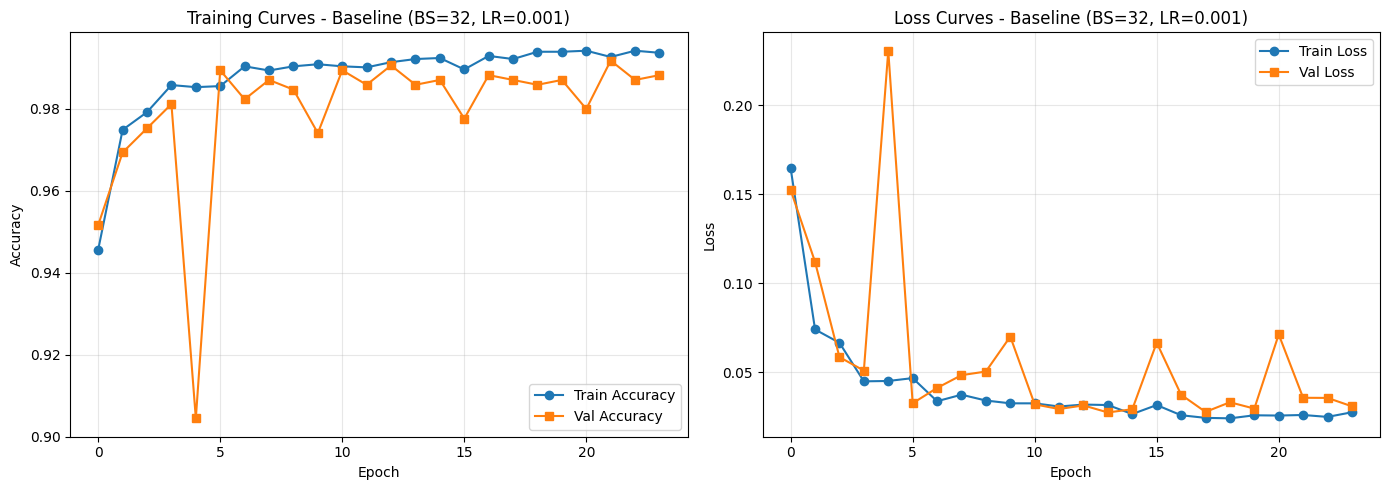

In [35]:
# Plot results immediately after experiment
print(f"\nPlotting results for: {experiments[0]['name']}")
plot_training_curves(result1)

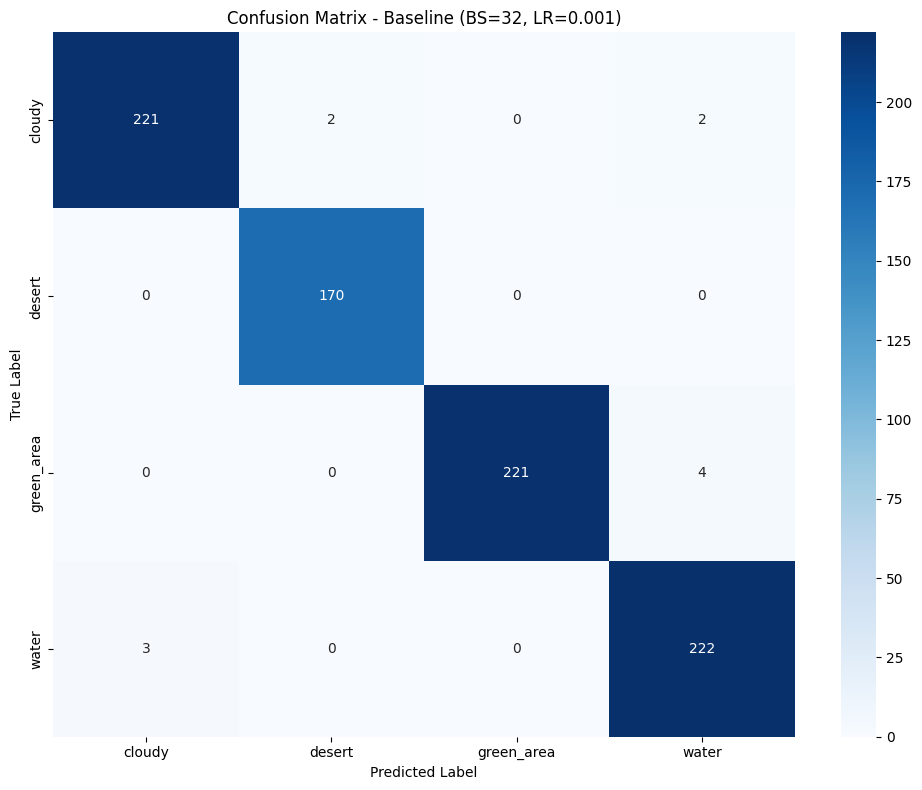

In [31]:
plot_confusion_matrix(result1)

## **2-Low LR (transfer learning, LR=0.0001, BS=32)**

In [38]:
# Run Experiment 5: Low LR (Frozen, No Augmentation)
result2 = run_experiment(
    experiment_name=experiments[4]['name'],
    freeze_base=experiments[4]['freeze_base'],
    use_augmentation=experiments[4]['use_augmentation'],
    learning_rate=experiments[4]['learning_rate'],
    batch_size=experiments[4]['batch_size'],
    epochs=EPOCHS,
    patience=PATIENCE
)
all_results.append(result2)
print("\n" + "="*60 + "\n")



EXPERIMENT: Low LR (BS=32, LR=0.0001)
  Freeze Base: True
  Augmentation: False
  Learning Rate: 0.0001
  Batch Size: 32
  Max Epochs: 50
Found 3938 images belonging to 4 classes.
Found 848 images belonging to 4 classes.
Found 845 images belonging to 4 classes.
 base layers frozen (transfer learning mode)
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


124/124 ━━━━━━━━━━━━━━━━━━━━ 27s 144ms/step - accuracy: 0.6778 - loss: 0.8705 - val_accuracy: 0.8479 - val_loss: 0.3841
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.9530 - loss: 0.1574 - val_accuracy: 0.9658 - val_loss: 0.1552
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9639 - loss: 0.1204 - val_accuracy: 0.9752 - val_loss: 0.0855
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9738 - loss: 0.0901 - val_accuracy: 0.9764 - val_loss: 0.0738
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9792 - loss: 0.0704 - val_accuracy: 0.9823 - val_loss: 0.0598
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9807 - loss: 0.0676 - val_accuracy: 0.9835 - val_loss: 0.0506
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9838 - loss: 0.0562 - val_accuracy: 0.9847 - val_loss: 0.0467
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9852 - loss: 0.0507 - val_accuracy: 0.9


Plotting results for: Low LR (BS=32, LR=0.0001)


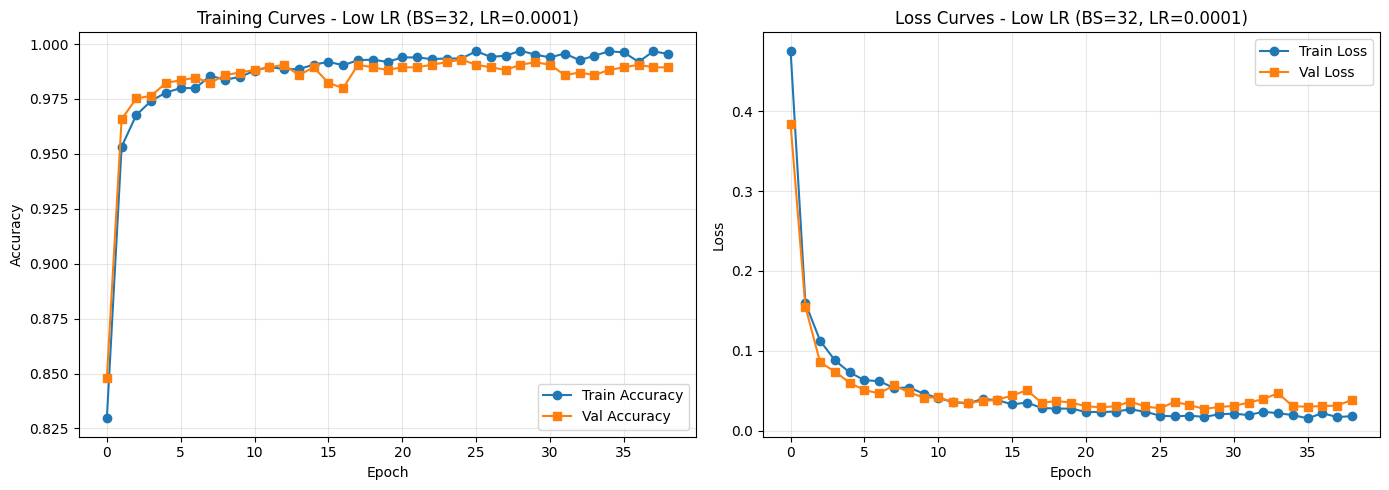

In [39]:
# Plot results immediately after experiment
print(f"\nPlotting results for: {experiments[4]['name']}")
plot_training_curves(result2)

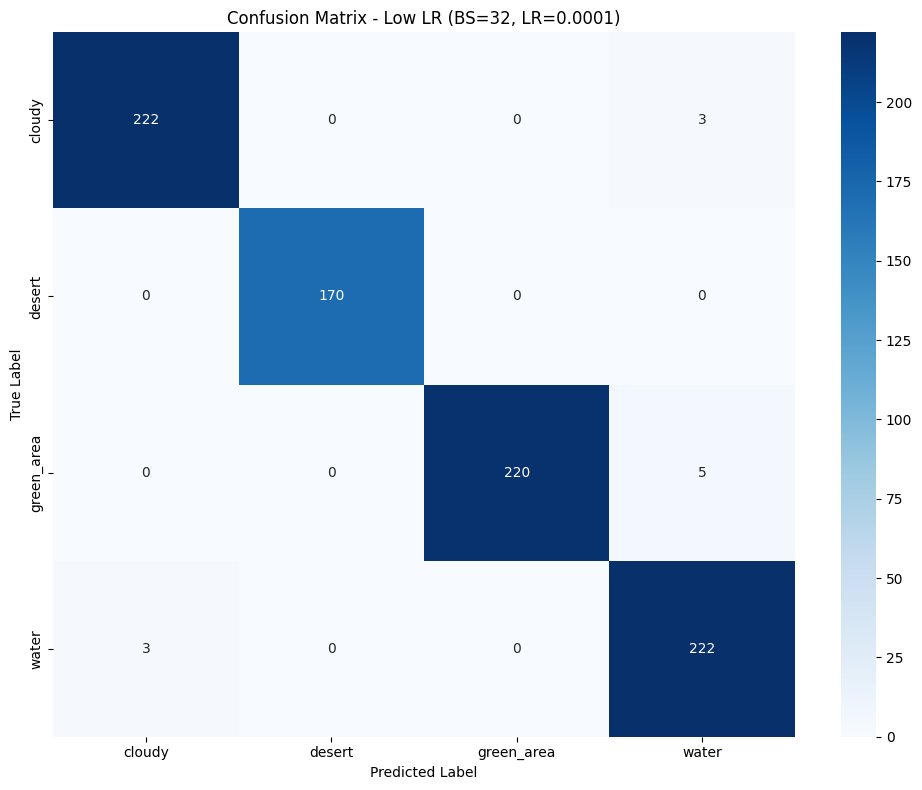

In [40]:
plot_confusion_matrix(result2)

## **3-Large BS (transfer learning, LR=0.001, BS=64)**

In [41]:
# Run Experiment 3: Large Batch (Frozen, No Augmentation)
result3 = run_experiment(
    experiment_name=experiments[2]['name'],
    freeze_base=experiments[2]['freeze_base'],
    use_augmentation=experiments[2]['use_augmentation'],
    learning_rate=experiments[2]['learning_rate'],
    batch_size=experiments[2]['batch_size'],
    epochs=EPOCHS,
    patience=PATIENCE
)
all_results.append(result3)
print("\n" + "="*60 + "\n")



EXPERIMENT: Large Batch (BS=64, LR=0.001)
  Freeze Base: True
  Augmentation: False
  Learning Rate: 0.001
  Batch Size: 64
  Max Epochs: 50
Found 3938 images belonging to 4 classes.
Found 848 images belonging to 4 classes.
Found 845 images belonging to 4 classes.
 base layers frozen (transfer learning mode)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 47s 476ms/step - accuracy: 0.8553 - loss: 0.4056 - val_accuracy: 0.8667 - val_loss: 0.2999
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.9802 - loss: 0.0692 - val_accuracy: 0.9717 - val_loss: 0.1211
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9845 - loss: 0.0530 - val_accuracy: 0.9811 - val_loss: 0.0681
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9873 - loss: 0.0410 - val_accuracy: 0.9858 - val_loss: 0.0453
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9874 - loss: 0.0377 - val_accuracy: 0.9870 - val_loss: 0.0396
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9915 - loss: 0.0272 - val_accuracy: 0.9847 - val_loss: 0.0499
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9898 - loss: 0.0301 - val_accuracy: 0.9823 - val_loss: 0.0474
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9940 - loss: 0.0233 - val_accuracy: 0


Plotting results for: Large Batch (BS=64, LR=0.001)


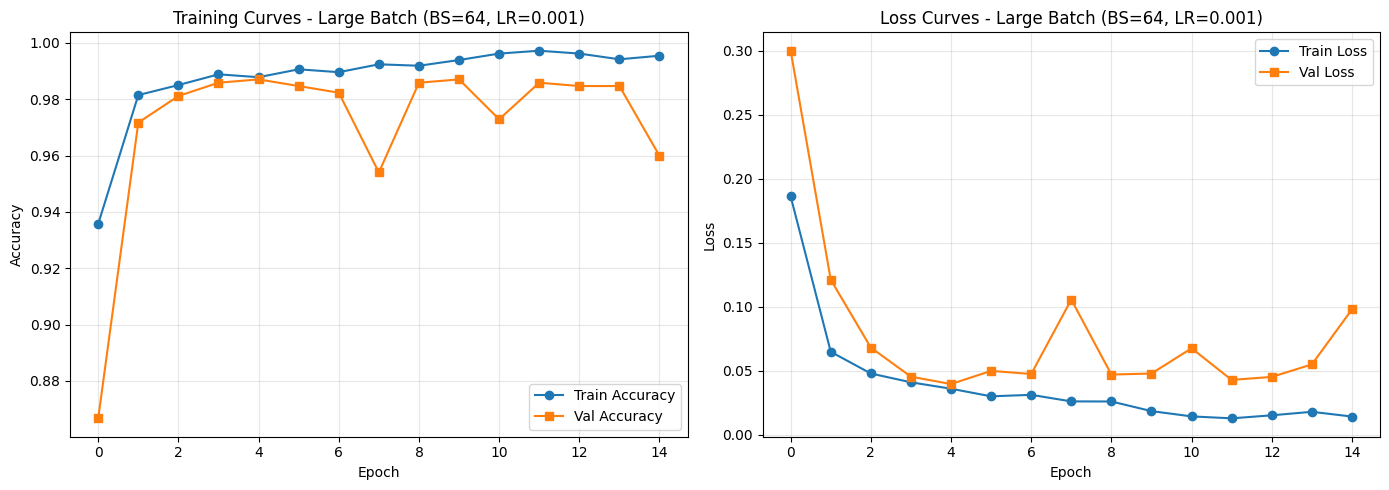

In [42]:
# Plot results immediately after experiment
print(f"\nPlotting results for: {experiments[2]['name']}")
plot_training_curves(result3)

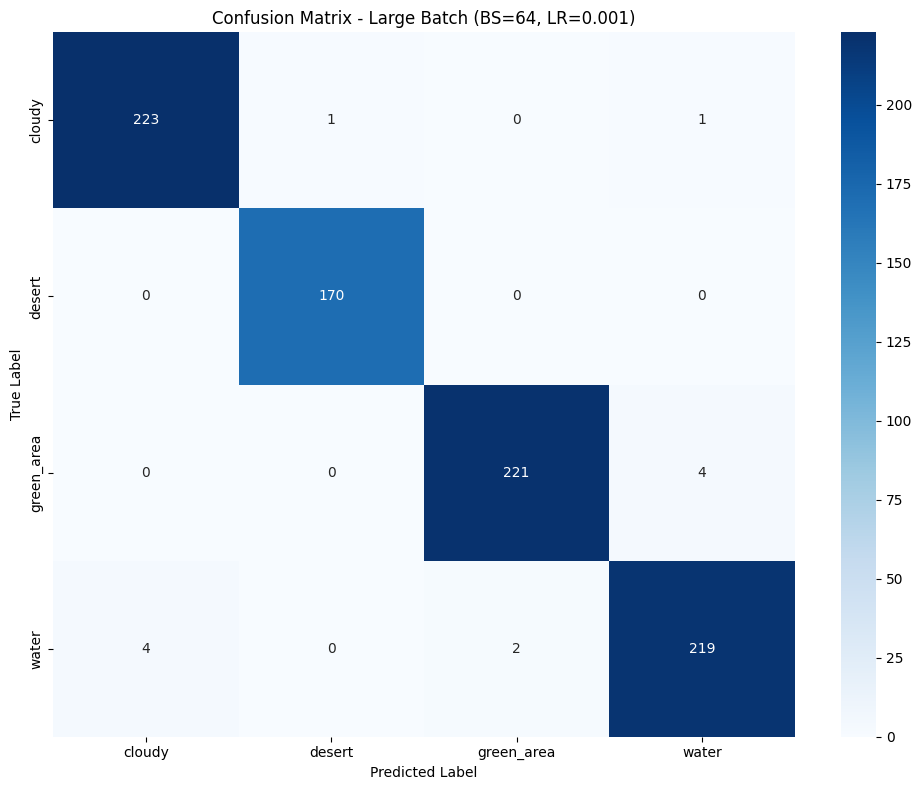

In [43]:
plot_confusion_matrix(result3)

## **Compare Results**

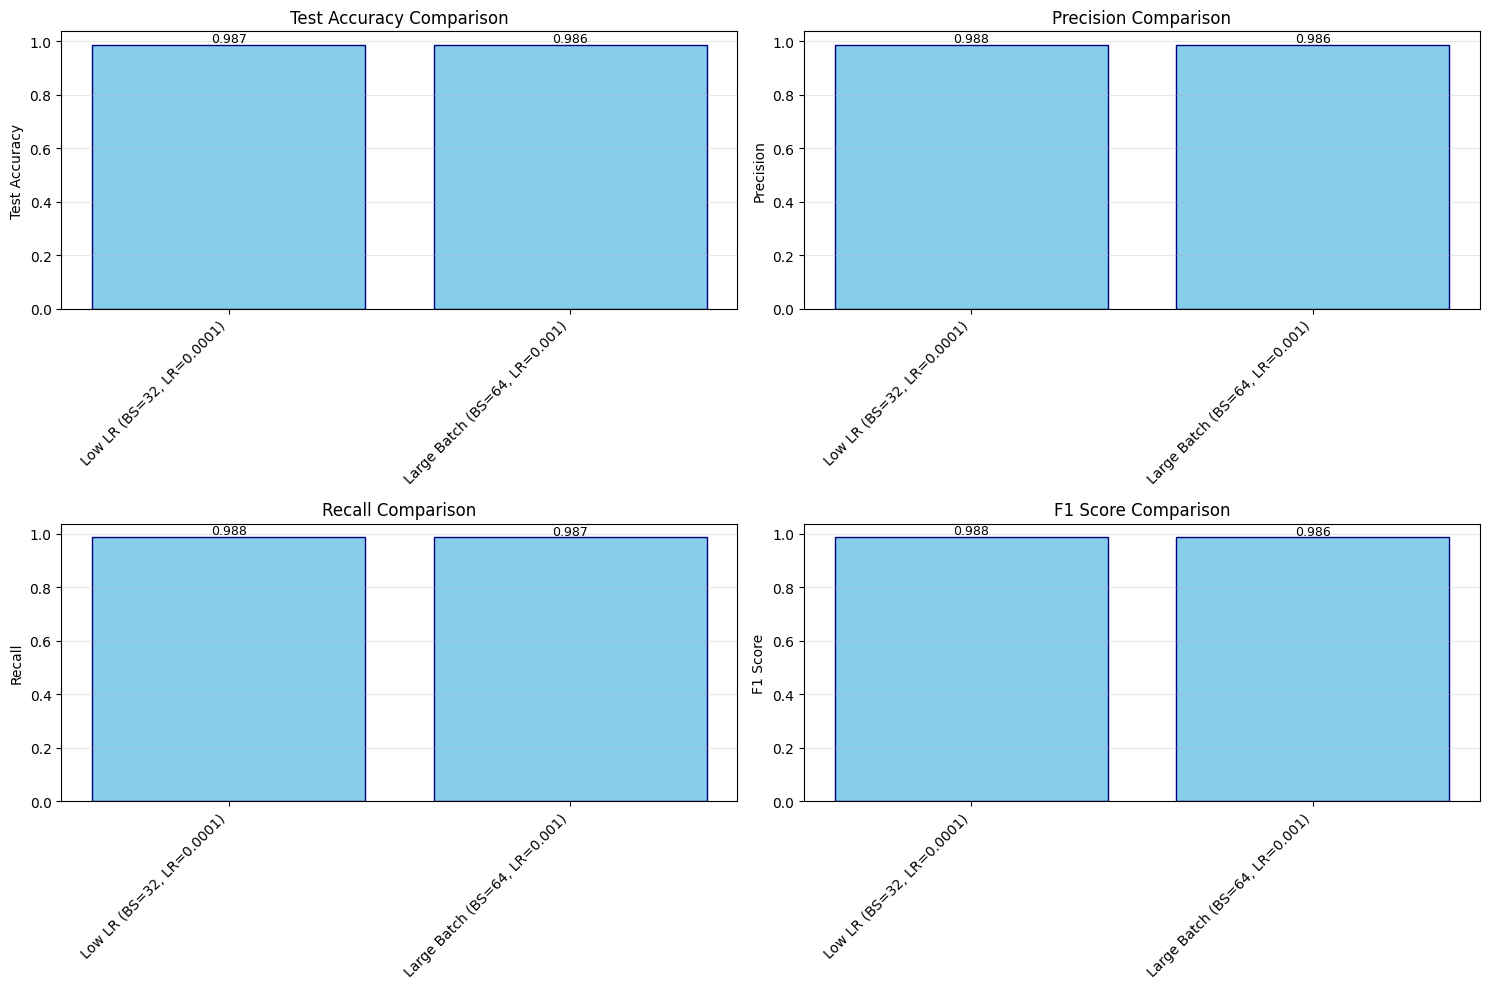

In [46]:
compare_experiments(all_results)